In [1]:
import os
import pathlib
import random
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from skimage import io
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.util import img_as_ubyte

In [2]:
def read_landmark_file(file_name):
    f = open(file_name, 'r')
    lm_s = f.readline().strip().split(' ')
    n_lms = int(lm_s[0])
    if n_lms < 3:
        print(f"Not enough landmarks found")
        return None

    new_lms = 3
    # 3 landmarks each with (x,y)
    lm = np.zeros((new_lms, 2))
    for i in range(new_lms):
        lm[i, 0] = lm_s[1 + i * 2]
        lm[i, 1] = lm_s[2 + i * 2]
    return lm

def align_and_crop_one_cat_to_destination_cat(img_src, lm_src, img_dst, lm_dst):
    """
    Landmark based alignment of one cat image to a destination
    :param img_src: Image of source cat
    :param lm_src: Landmarks for source cat
    :param lm_dst: Landmarks for destination cat
    :return: Warped and cropped source image. None if something did not work
    """
    tform = SimilarityTransform()
    tform.estimate(lm_src, lm_dst)
    warped = warp(img_src, tform.inverse, output_shape=img_dst.shape)

    # Center of crop region
    cy = 185
    cx = 210
    sz = 180           # half the size of the crop box
    warp_crop = warped[cy - sz:cy + sz, cx - sz:cx + sz]
    shape = warp_crop.shape
    if shape[0] == sz * 2 and shape[1] == sz * 2:
        return img_as_ubyte(warp_crop)
    else:
        print(f"Could not crop image. It has shape {shape}. Probably to close to border of image")
        return None
    
def preprocess_all_cats(in_dir, out_dir):
    """
    Create aligned and cropped version of image
    :param in_dir: Where are the original photos and landmark files
    :param out_dir: Where should the preprocessed files be placed
    """
    dst = "data/ModelCat"
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")
    dst_img = io.imread(f"{dst}.jpg")

    all_images = glob.glob(in_dir + "*.jpg")
    for img_idx in all_images:
        name_no_ext = os.path.splitext(img_idx)[0]
        base_name = os.path.basename(name_no_ext)
        out_name = f"{out_dir}/{base_name}_preprocessed.jpg"

        src_lm = read_landmark_file(f"{name_no_ext}.jpg.cat")
        src_img = io.imread(f"{name_no_ext}.jpg")

        proc_img = align_and_crop_one_cat_to_destination_cat(src_img, src_lm,
                                                             dst_img, dst_lm)
        if proc_img is not None:
            io.imsave(out_name, proc_img)
            
def preprocess_one_cat():
    src = "data/MissingCat"
    dst = "data/ModelCat"
    out = "data/MissingCatProcessed.jpg"

    src_lm = read_landmark_file(f"{src}.jpg.cat")
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")

    src_img = io.imread(f"{src}.jpg")
    dst_img = io.imread(f"{dst}.jpg")

    src_proc = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, 
                                                         dst_img, dst_lm)
    if src_proc is None:
        return

    io.imsave(out, src_proc)

    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
    ax[0].imshow(src_img)
    ax[0].plot(src_lm[:, 0], src_lm[:, 1], '.r', markersize=12)
    ax[1].imshow(dst_img)
    ax[1].plot(dst_lm[:, 0], dst_lm[:, 1], '.r', markersize=12)
    ax[2].imshow(src_proc)
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()
    
def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

In [3]:
# exercise 1: preprocess all cats
raw_dir = "data/training_data/"
preprocess_dir = "data/processed_training_cats_100/"

if not os.path.exists(preprocess_dir):
    os.makedirs(preprocess_dir)
    preprocess_all_cats(raw_dir, preprocess_dir)

In [4]:
# exercise 2: compute data matrix
all_images = glob.glob(preprocess_dir + "*.jpg")  # make list of path to all images
n_samples = len(all_images)

# read first image
first_img = io.imread(all_images[0])
height, width, channels = first_img.shape
n_features = height*width*channels

print("n_samples: ", n_samples)
print("n_features: ", n_features)

data_matrix = np.zeros((n_samples, n_features))
for idx,img_path in enumerate(all_images):
    img = io.imread(img_path)
    data_matrix[idx,:] = img.flatten()
    

n_samples:  100
n_features:  388800


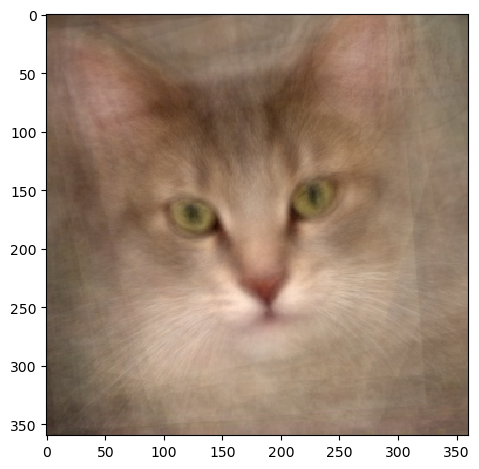

In [5]:
# exercise 3: compute average cat
avg_cat = np.mean(data_matrix,axis=0)
avg_cat_img = create_u_byte_image_from_vector(avg_cat, height, width, channels)

# exercise 4: visualise mean cat
io.imshow(avg_cat_img)
io.show()

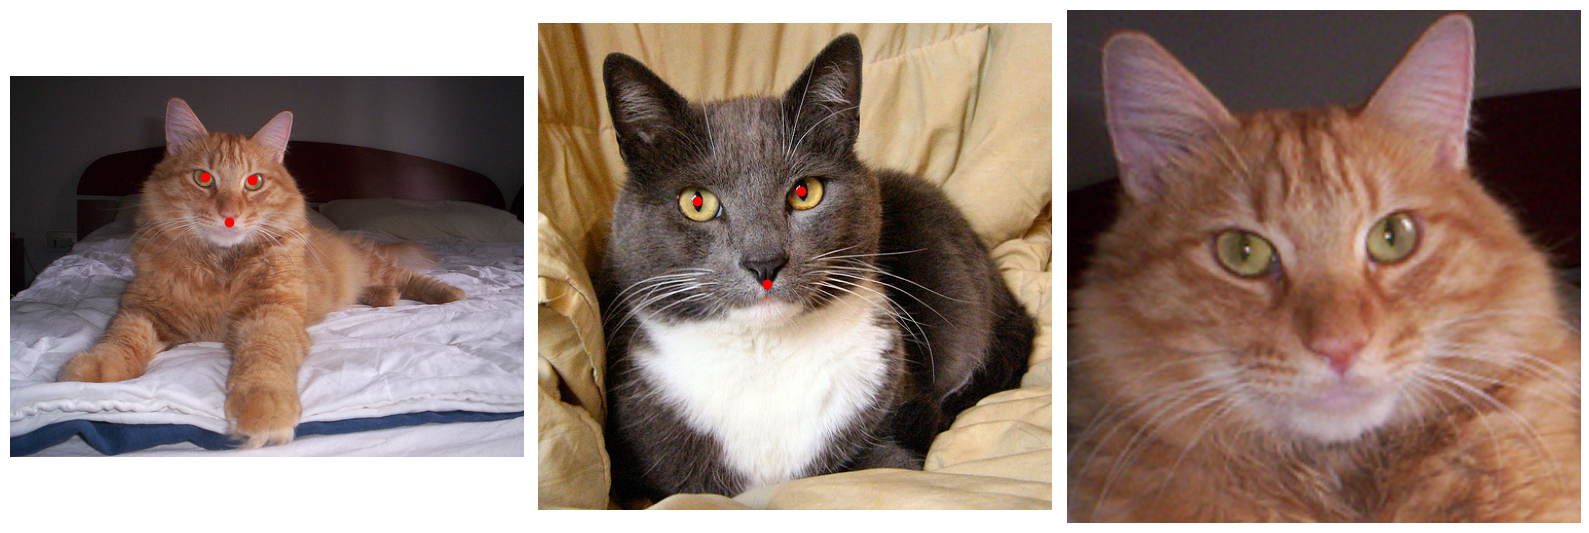

In [6]:
# exercise 6: preprocess the photo of the missing cat
preprocess_one_cat()

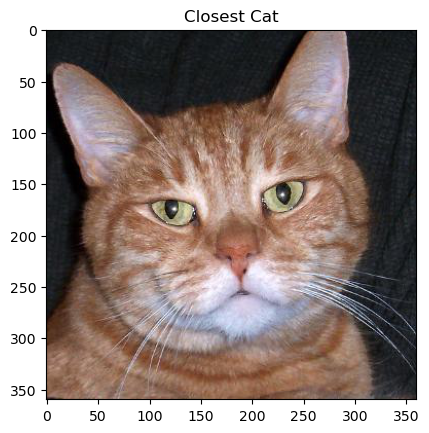

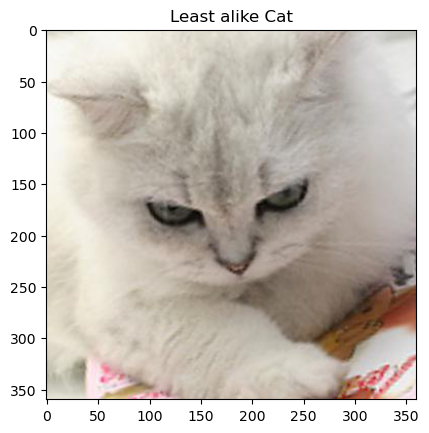

In [7]:
# exercise 7: Flatten the pixel values of the missing cat
im_miss = io.imread('data\MissingCatProcessed.jpg')
im_miss_flat = im_miss.flatten()

# exercise 8: compute sum of squared differences
sub_data = data_matrix - im_miss_flat
sub_distances = np.linalg.norm(sub_data, axis=1)

# exercise 9: find training cat with smallest SSD
cat_idx = np.argmin(sub_distances)

# exercise 10: visualise closest cat
im_closest = io.imread(all_images[cat_idx])
plt.imshow(im_closest)
plt.title('Closest Cat')
plt.show()

# exercise 11: find training cat with largest SSD
cat_idx = np.argmax(sub_distances)
im_least = io.imread(all_images[cat_idx])
plt.imshow(im_least)
plt.title('Least alike Cat')
plt.show()

In [8]:
# exercise 12: compute the first 50 principal components
print("Computing PCA")
n_comps = 50
cats_pca = PCA(n_components=n_comps)
cats_pca.fit(data_matrix)

Computing PCA


PCA(n_components=50)

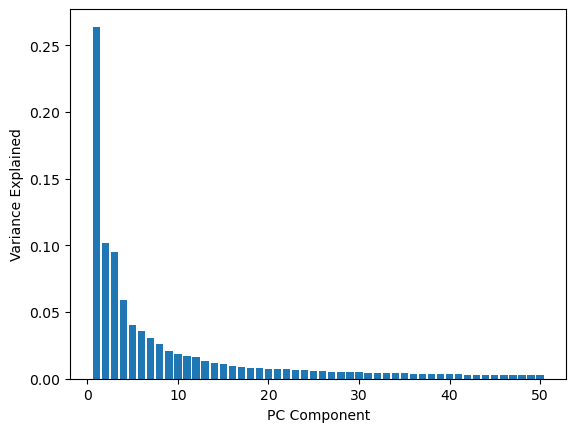

In [9]:
# exercise 13: plot amt of total variation explained
plt.bar(range(1,n_comps+1),cats_pca.explained_variance_ratio_)
plt.ylabel("Variance Explained")
plt.xlabel("PC Component")
plt.show()

In [10]:
# exercise 14: PC1 explains
print(f'PC1 explains {cats_pca.explained_variance_ratio_[0]:.2f} total variation')

PC1 explains 0.26 total variation


In [11]:
# exercise 15: Project the cat images into PCA space
components = cats_pca.transform(data_matrix)

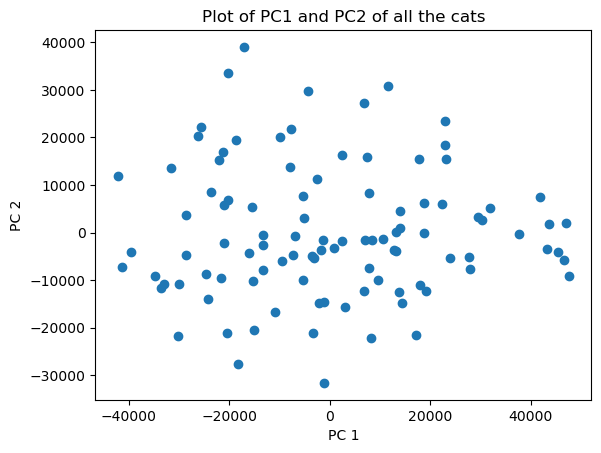

In [12]:
# exercise 16: Plot the PCA space by plotting all the cats first 
# and second PCA coordinates in a (x, y) plot
pc_1 = components[:, 0]
pc_2 = components[:, 1]
plt.scatter(pc_1,pc_2)
plt.ylabel("PC 2")
plt.xlabel("PC 1")
plt.title("Plot of PC1 and PC2 of all the cats")
plt.show()

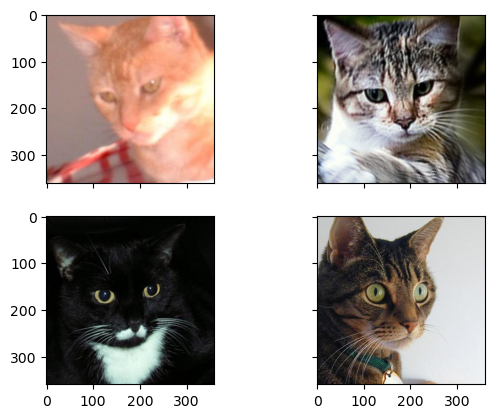

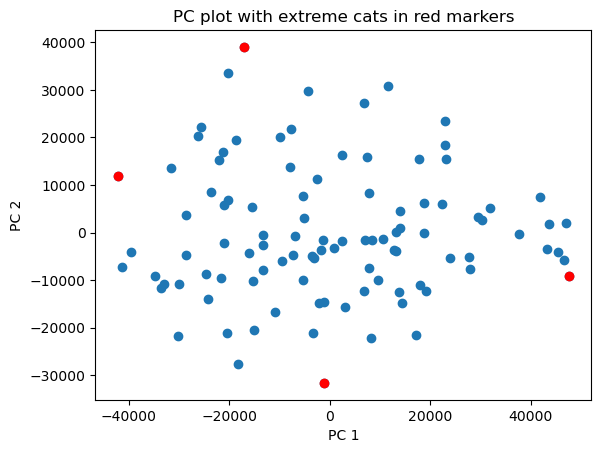

In [13]:
# exercise 17: visualise extreme cats
min_cat1 = np.argmin(pc_1)
min_cat2 = np.argmin(pc_2)
max_cat1 = np.argmax(pc_1)
max_cat2 = np.argmax(pc_2)

fig,axs = plt.subplots(2,2,sharex=True,sharey=True)
cat_min1 = create_u_byte_image_from_vector(data_matrix[min_cat1], height, width, channels)
cat_min2 = create_u_byte_image_from_vector(data_matrix[min_cat2], height, width, channels)
cat_max1 = create_u_byte_image_from_vector(data_matrix[max_cat1], height, width, channels)
cat_max2 = create_u_byte_image_from_vector(data_matrix[max_cat2], height, width, channels)
axs[0,0].imshow(cat_min1)
axs[0,1].imshow(cat_min2)
axs[1,0].imshow(cat_max1)
axs[1,1].imshow(cat_max2)
plt.show()

extreme_cats = [min_cat1,min_cat2,max_cat1,max_cat2]
plt.scatter(pc_1,pc_2)
plt.plot(components[extreme_cats,0],components[extreme_cats,1],'ro')
plt.ylabel("PC 2")
plt.xlabel("PC 1")
plt.title("PC plot with extreme cats in red markers")
plt.show()

In [15]:
def nargmax(arr, n):
    # Like np.argmax but returns the n largest values
    idx = np.argpartition(arr, -n)[-n:]
    return idx[np.argsort(arr[idx])][::-1]

def nargmin(arr, n):
    # Like np.argmin but returns the n smallest values
    idx = np.argpartition(arr, n)[:n]
    return idx[np.argsort(arr[idx])]

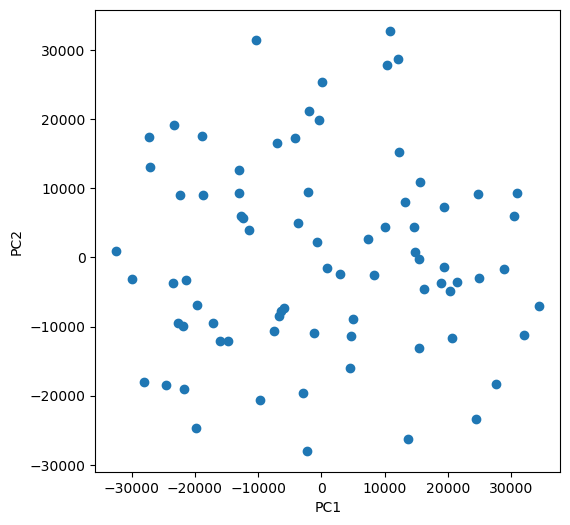

In [16]:
# exercise 18: modify training set, remove photos with bad quality.
filtered_matrix = data_matrix.copy()

# Remove the 8 largest values of PC1, 5 smallest values of PC1,
# 5 largest values of PC2 and 5 smallest values of PC2
max_pc1s = nargmax(pc_1, 8)
min_pc1s = nargmin(pc_1, 5)
max_pc2s = nargmax(pc_2, 5)
min_pc2s = nargmin(pc_2, 5)

remove_idx = np.concatenate((max_pc1s, min_pc1s, max_pc2s, min_pc2s))
filtered_matrix = np.delete(filtered_matrix, remove_idx, axis=0)

# Recompute PCA
cats_pca = PCA(n_components=50)
cats_pca.fit(filtered_matrix)
components = cats_pca.transform(filtered_matrix)

pc_1 = components[:, 0] 
pc_2 = components[:, 1]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(pc_1, pc_2, "o")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

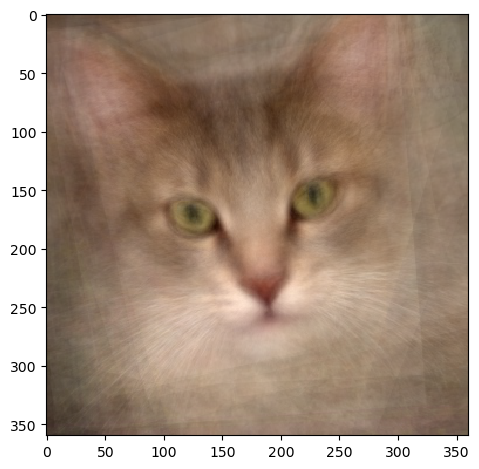

In [17]:
# exercise 19: Create first fake cat using the average image and
# the first principal component. 
w = 1000
synth_cat = avg_cat + w * cats_pca.components_[0, :]

# exercise 20: visualise fake cat
io.imshow(create_u_byte_image_from_vector(synth_cat,height,width,channels))
io.show()

Maximal value of PC2: 0.00431842
Minimal value of PC2: -0.00311438


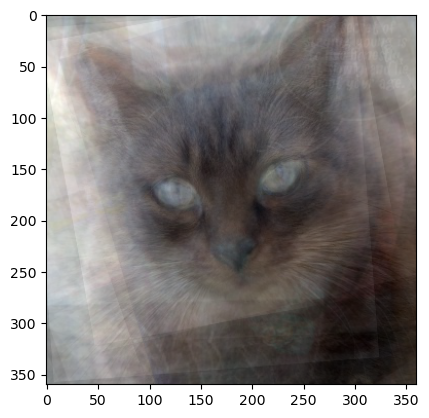

In [18]:
# exercise 21: synthesise cast based on 1st and 2nd PC
print("Maximal value of PC2: {:.8f}".format(np.max(cats_pca.components_[1, :])))
print("Minimal value of PC2: {:.8f}".format(np.min(cats_pca.components_[1, :])))

w0, w1 = 60000, 60000
synth_cat = avg_cat + w0 * cats_pca.components_[0, :] + w1 * cats_pca.components_[1, :]
synth_cat_img = create_u_byte_image_from_vector(synth_cat, height, width, channels)
plt.imshow(synth_cat_img)
plt.show()

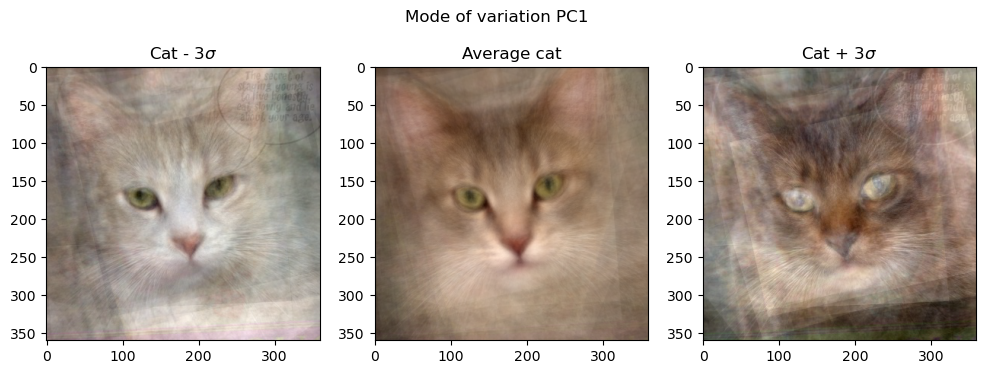

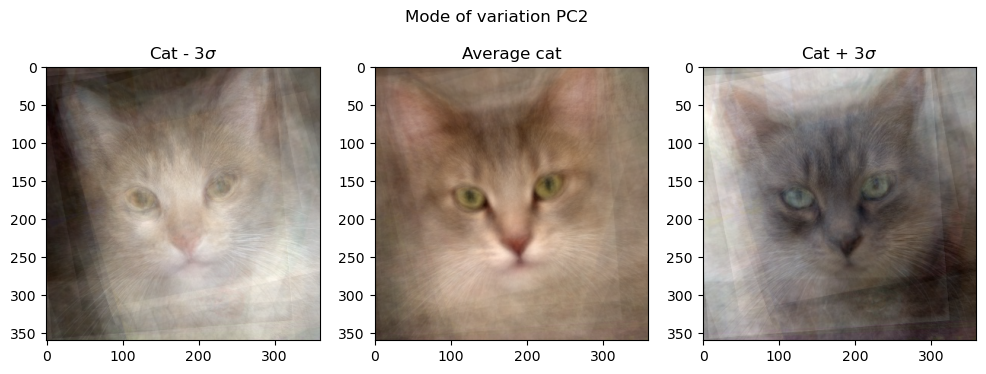

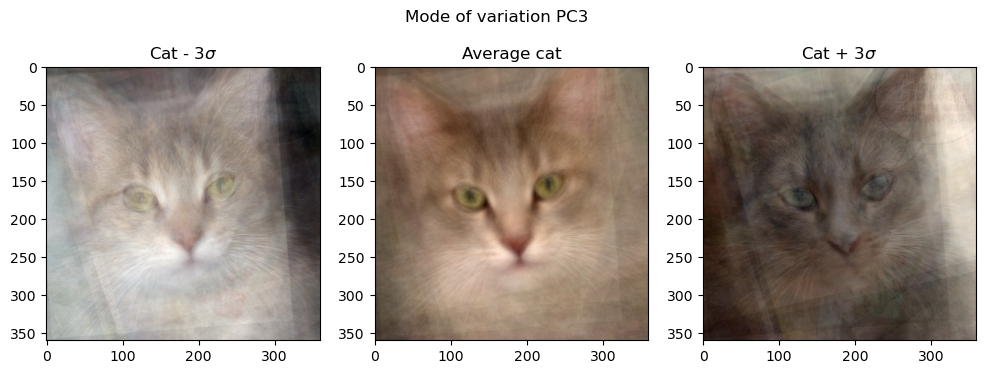

In [19]:
# exercise 22: modes of variation
def visualize_mode_of_variation(m):
    synth_cat_plus = avg_cat + 3 * np.sqrt(cats_pca.explained_variance_[m]) * cats_pca.components_[m, :]
    synth_cat_minus = avg_cat - 3 * np.sqrt(cats_pca.explained_variance_[m]) * cats_pca.components_[m, :]
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(create_u_byte_image_from_vector(synth_cat_minus, height, width, channels))
    ax[0].set_title("Cat - 3$\sigma$")
    ax[1].imshow(create_u_byte_image_from_vector(avg_cat, height, width, channels))
    ax[1].set_title("Average cat")
    ax[2].imshow(create_u_byte_image_from_vector(synth_cat_plus, height, width, channels))
    ax[2].set_title("Cat + 3$\sigma$")
    fig.suptitle("Mode of variation PC{}".format(m + 1))
    
visualize_mode_of_variation(m=0)
visualize_mode_of_variation(m=1)
visualize_mode_of_variation(m=2)

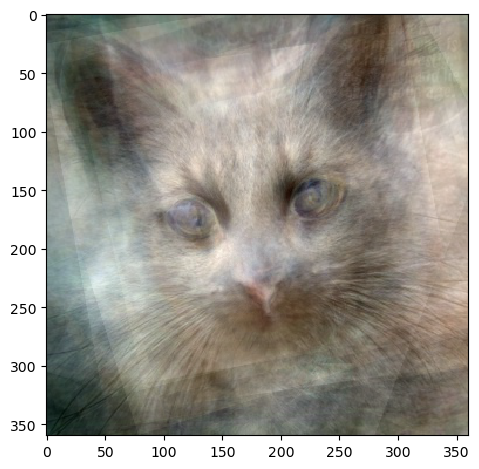

In [20]:
# exercise 23: cat synthesizer
n_components_to_use = 10
synth_cat = avg_cat
for idx in range(n_components_to_use):
    w = random.uniform(-1, 1) * 3 * np.sqrt(cats_pca.explained_variance_[idx])
    synth_cat = synth_cat + w * cats_pca.components_[idx, :]
io.imshow(create_u_byte_image_from_vector(synth_cat,height,width,channels))
io.show()

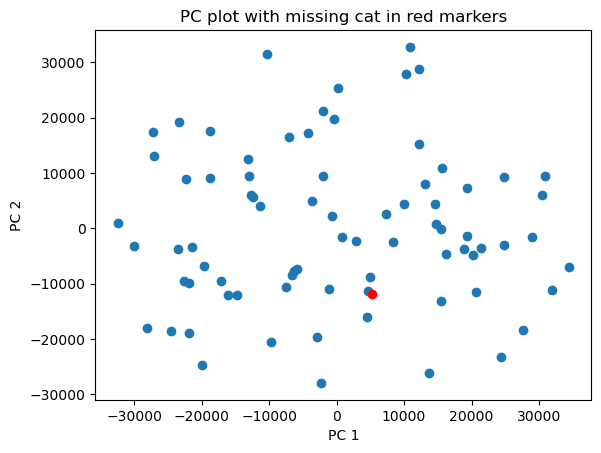

In [21]:
# exercise 24: PCA space coordinates of missing cat
im_miss = io.imread("data/MissingCatProcessed.jpg")
im_miss_flat = im_miss.flatten()
im_miss_flat = im_miss_flat.reshape(1, -1)
pca_coords = cats_pca.transform(im_miss_flat)
pca_coords = pca_coords.flatten()

# exercise 25: plot missing cat in PCA space
plt.scatter(pc_1,pc_2)
plt.plot(pca_coords[0],pca_coords[1],'ro')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PC plot with missing cat in red markers")
plt.show()

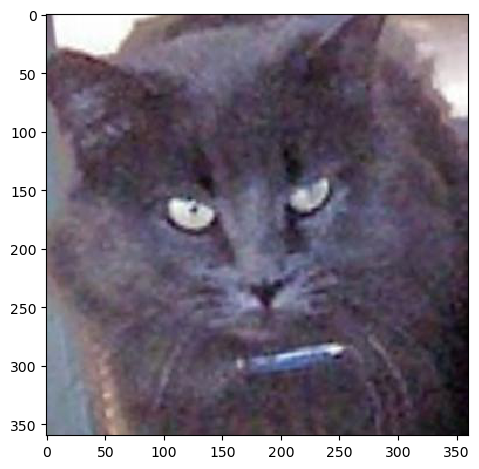

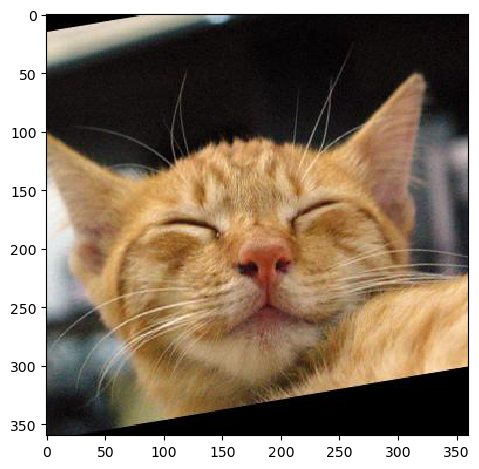

In [22]:
# exercise 26: generate synthetic version of missing cat
n_components_to_use = 10
synth_cat = avg_cat
for idx in range(n_components_to_use):
    synth_cat = synth_cat + pca_coords[idx] * cats_pca.components_[idx, :]
    



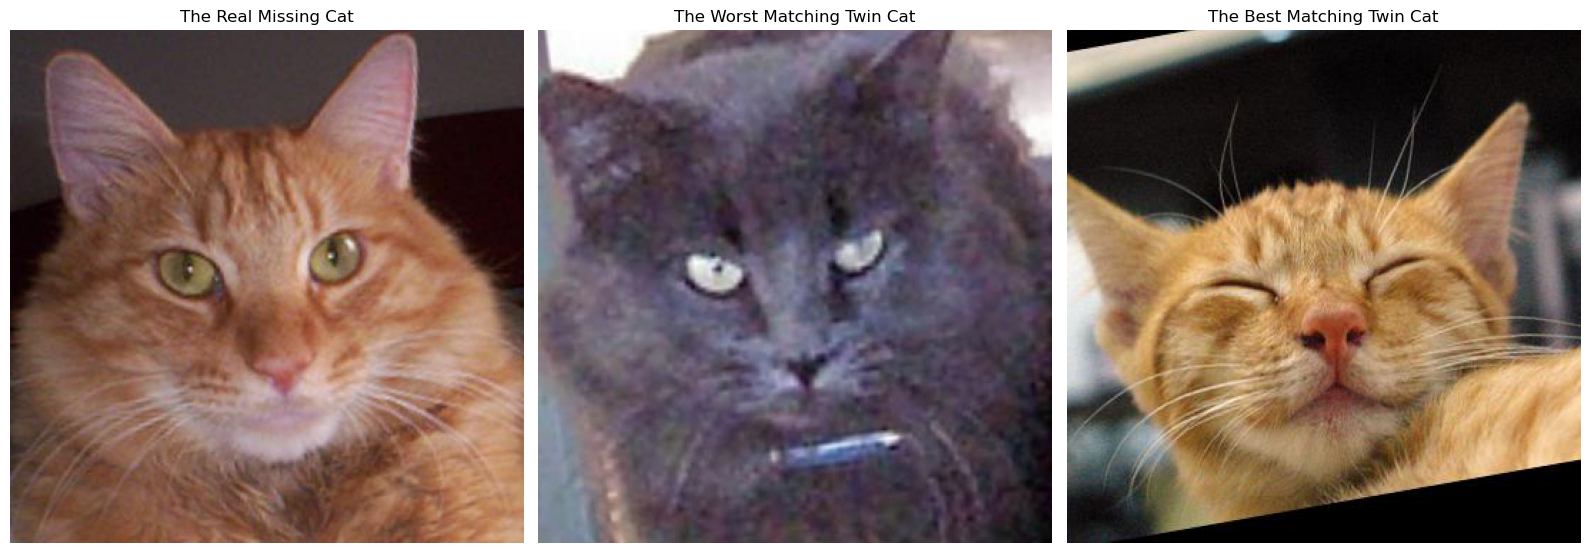

In [25]:
# exercise 27: find smallest and largest distance cat
comp_sub = components - pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)
min_cat_idx = np.argmin(pca_distances)
max_cat_idx = np.argmax(pca_distances)


fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
ax[0].imshow(im_miss)
ax[0].set_title('The Real Missing Cat')
ax[1].imshow(create_u_byte_image_from_vector(data_matrix[min_cat_idx], height, width, channels))
ax[1].set_title('The Worst Matching Twin Cat')
ax[2].imshow(create_u_byte_image_from_vector(data_matrix[max_cat_idx], height, width, channels))
ax[2].set_title('The Best Matching Twin Cat')
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

# io.imshow(create_u_byte_image_from_vector(data_matrix[min_cat_idx],height,width,channels))
# io.show()
# io.imshow(create_u_byte_image_from_vector(data_matrix[max_cat_idx],height,width,channels))
# io.show()

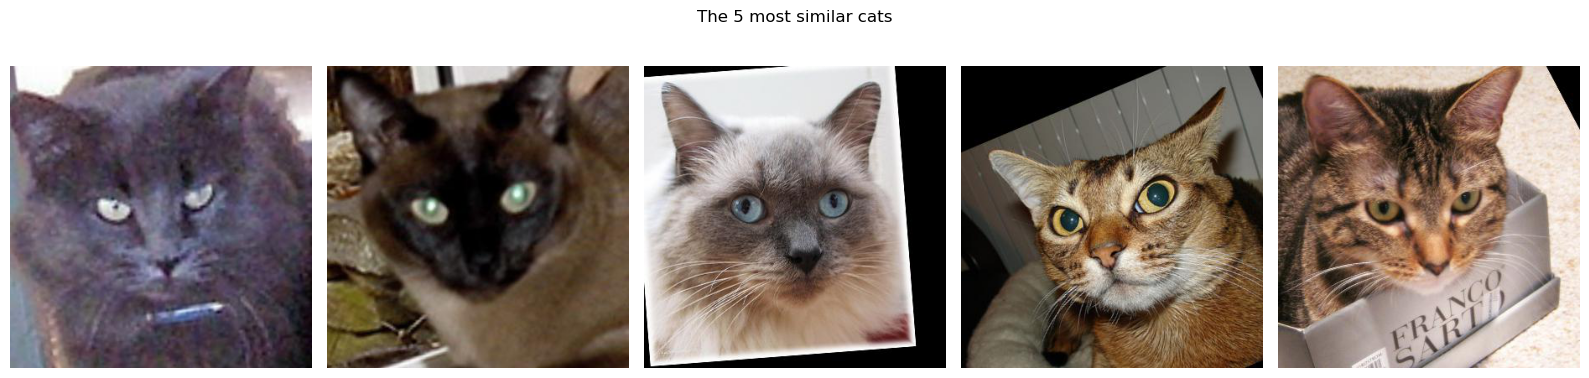

In [26]:
# exercise 28: visualise closest 5 casts in PCA space
n_best = 5
best = np.argpartition(pca_distances, n_best)
fig, ax = plt.subplots(ncols=n_best, figsize=(16, 4))
for i in range(n_best):
    candidate_twin_cat = data_matrix[best[i], :]
    ax[i].imshow(create_u_byte_image_from_vector(candidate_twin_cat, height, width, channels))
    ax[i].axis('off')

fig.suptitle(f"The {n_best} most similar cats")
plt.tight_layout()
plt.show()